Q1,Q2 & Q3

In [429]:
#Input images are taken of 28*28

In [430]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [431]:
print(torch.__version__)

1.10.0+cpu


In [432]:
class Convnet:

    def __init__(self, filtercount, size_of_filter, paddingwidth):

        self.size_of_filter = size_of_filter
        self.paddingwidth = paddingwidth
        self.filtercount = filtercount
        self.convfilter = np.random.randn(filtercount, size_of_filter, size_of_filter) / (
                    size_of_filter * size_of_filter)

    def image_window(self, image):
        self.image = image
        height, width = image.shape

        for j in range(height - self.size_of_filter + 1):
            for k in range(width - self.size_of_filter + 1):
                image_patch = image[j:(j + self.size_of_filter), k:(k + self.size_of_filter)]
                yield image_patch, j, k

    def forward_propogation(self, image):
        height, width = image.shape
        m, n = round((height - self.size_of_filter + 2 * self.paddingwidth)) + 1, round((width - self.size_of_filter + 2 * self.paddingwidth)) + 1
        conv_output = np.zeros((m, n, self.filtercount))

        for patch, i, j in self.image_window(image):
            conv_output[i, j] = np.sum(patch * self.convfilter, axis=(1, 2))
        self.conv_out=conv_output
        return conv_output

    def back_propogation(self, back_out, learning_rate):

        params = np.zeros(self.convfilter.shape)

        for image_patch, i, j in self.image_window(self.image):
            for k in range(self.filtercount):
                params[k] += image_patch * back_out[i, j, k]

        # filter Params Update
        self.convfilter -= learning_rate * params
        return params


In [433]:
def drawing(image):
    plt.imshow(image)
    plt.title(str(image.shape))
    plt.style.use("seaborn")
    plt.show()

In [434]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])



mnist_test = datasets.MNIST(root='D:\Deep Learning', train=False, download=True, transform=transform)

mnist_train = datasets.MNIST(root='D:\Deep Learning', train=True, download=True, transform=transform)

image1 = mnist_train[1][0]
image1.shape

torch.Size([1, 28, 28])

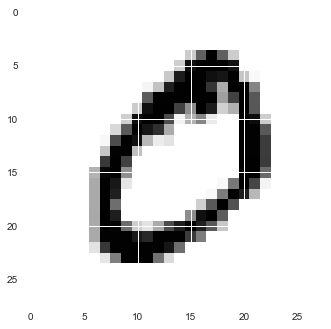

In [435]:
plt.imshow(image1.numpy().squeeze(), cmap='gray_r')

image1.shape
image1 = image1.numpy()

image1 = image1.transpose(1, 2, 0)
image1.shape

img = image1.reshape(28, 28)

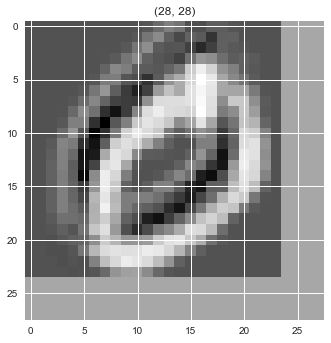

In [436]:
convnet = Convnet(4, 5, 2)
out = convnet.forward_propogation(img)
out.shape

drawing(out[:, :, 3])

In [437]:
class Max_Pool:

    def __init__(self, filter_size):
        self.filter_size = filter_size

    def image_region(self, image):
        new_height = image.shape[0] // self.filter_size
        new_width = image.shape[1] // self.filter_size

        self.image = image

        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[(i * self.filter_size):(i * self.filter_size + self.filter_size),
                              (j * self.filter_size):(j * self.filter_size + self.filter_size)]
                yield image_patch, i, j

    def forward_prop(self, image):

        height, width, num_filters = image.shape
        output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

        for image_patch, i, j in self.image_region(image):
            output[i, j] = np.amax(image_patch, axis=(0, 1))

        return output

    def back_prop(self, dL_dout):
        dL_dmax_pool = np.zeros(self.image.shape)

        for image_patch, i, j in self.image_region(self.image):
            height, width, num_filters = image_patch.shape
            maximum_val = np.amax(image_patch, axis=(0, 1))

            for i1 in range(height):
                for j1 in range(width):
                    for k1 in range(num_filters):
                        if image_patch[i1, j1, k1] == maximum_val[k1]:
                            dL_dmax_pool[i * self.filter_size + i1, j * self.filter_size + j1, k1] = dL_dout[i, j, k1]

        return dL_dmax_pool

In [438]:
conn2 = Max_Pool(2)
out2 = conn2.forward_prop(out)
out2.shape

(14, 14, 4)

In [439]:
convnet = Convnet(4, 5, 2)
out = convnet.forward_propogation(img)
out.shape

(28, 28, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


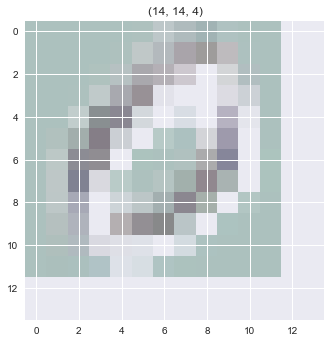

In [440]:
drawing(out2[:, :, :])

In [441]:
class Neuralnetwork:

    def __init__(self, inputnode, outputnode):
        self.weight = np.random.randn(inputnode, outputnode) / inputnode
        self.bias = np.zeros(outputnode)
        self.change = 0
        self.weight_config,self.bias_config=None,None

    def fwd_prop(self, image):

        self.original_image_shape = image.shape
        modified_image = image.flatten()
        self.bot=modified_image
        self.modified_input = modified_image
        #print(modified_image.shape)
        
        output_value = np.dot(modified_image, self.weight) + self.bias
        self.out = output_value
        expected_output = np.exp(output_value)
        return expected_output / np.sum(expected_output, axis=0)

    def back_propagation(self, dL_dout, learning_rate, variant, momentum):

        for i, grad in enumerate(dL_dout):
            if grad == 0:
                continue

            transformed_equation = np.exp(self.out)
            S_total = np.sum(transformed_equation)

            dy_dz = -transformed_equation[i] * transformed_equation / (S_total ** 2)
            dy_dz[i] = transformed_equation[i] * (S_total - transformed_equation[i]) / (S_total ** 2)

            dz_dw = self.modified_input
            dz_db = 1
            dz_d_inp = self.weight

            dL_dz = grad * dy_dz

            dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]

            dL_db = dL_dz * dz_db
            dL_d_inp = dz_d_inp @ dL_dz
            grad = dL_dw
            # calculate update
            if (variant=="vanilla"):
                new_change = learning_rate * grad
                self.weight -= new_change
                self.bias -= learning_rate * dL_db
            elif(variant=="momentum"):
                new_change = learning_rate * grad + momentum * self.change
                self.change = new_change
                self.weight -= new_change
                self.bias -= learning_rate * dL_db
            else:
                self.weight,self.weight_config=rmsprop(self.weight,dL_dw,self.weight_config)
                self.bias,self.bias_config=rmsprop(self.bias,dL_db,self.bias_config)
            
            return dL_d_inp.reshape(self.original_image_shape)

In [442]:
conn3 = Neuralnetwork(14 * 14 * 4, 10)
out3 = conn3.fwd_prop(out2)
#print(out3)

In [443]:


convolution = Convnet(4, 5, 2)
pooling = Max_Pool(2)
convolution1 = Convnet(4, 5, 2)
pooling1 = Max_Pool(2)
softmax = Neuralnetwork(14 * 14 * 4, 10)

In [444]:
def cnn_forward_propagation(image, label):
    output_p = convolution.forward_propogation((image / 255) - 0.5)
    output_p = pooling.forward_prop(output_p) 
    output_p2 = convolution1.forward_propogation((image / 255) - 0.5)
    output_p2 = pooling1.forward_prop(output_p2) 
    #output_p = pooling.forward_prop(output_p) 
    ##ADD one more conv and pooling
    output_p = softmax.fwd_prop(output_p)

    cross_ent_loss = -np.log(output_p[label])
    accuracy_eval = 1 if np.argmax(output_p) == label else 0

    return output_p, cross_ent_loss, accuracy_eval


def training_cnn_function(image, label,variant,learning_rate=0.001, momentum=0.9):
    out, loss, acc = cnn_forward_propagation(image, label)

    gradient_formed = np.zeros(10)
    gradient_formed[label] = -1 / out[label]

    gradient_back = softmax.back_propagation(gradient_formed, learning_rate,variant, momentum)
    gradient_back = pooling.back_prop(gradient_back)
    gradient_back = convolution.back_propogation(gradient_back, learning_rate)

    return loss, acc

In [445]:
output_p = convolution.forward_propogation((images_trained[0] / 255) - 0.5)
conv_output=output_p
print(conv_output.shape)
output_p = pooling.forward_prop(output_p)

print(output_p.shape)
output_p = softmax.fwd_prop(output_p)


(28, 28, 4)
(14, 14, 4)


Epoch 1
1 of 100 :  Loss 0.000 and Accuracy:0%
101 of 100 :  Loss 2.302 and Accuracy:7%
201 of 100 :  Loss 2.298 and Accuracy:10%
301 of 100 :  Loss 2.293 and Accuracy:12%
401 of 100 :  Loss 2.291 and Accuracy:13%
501 of 100 :  Loss 2.277 and Accuracy:18%
601 of 100 :  Loss 2.269 and Accuracy:18%
701 of 100 :  Loss 2.242 and Accuracy:20%
801 of 100 :  Loss 2.217 and Accuracy:25%
901 of 100 :  Loss 2.203 and Accuracy:27%
Testing Phase
Test Loss 2.1104572558472285
Test Accuracy 0.412
Epoch 2
1 of 100 :  Loss 0.000 and Accuracy:0%
101 of 100 :  Loss 2.053 and Accuracy:38%
201 of 100 :  Loss 2.003 and Accuracy:40%
301 of 100 :  Loss 1.884 and Accuracy:52%
401 of 100 :  Loss 1.758 and Accuracy:58%
501 of 100 :  Loss 1.515 and Accuracy:67%
601 of 100 :  Loss 1.501 and Accuracy:59%
701 of 100 :  Loss 1.266 and Accuracy:64%
801 of 100 :  Loss 1.225 and Accuracy:58%
901 of 100 :  Loss 1.102 and Accuracy:65%
Testing Phase
Test Loss 1.048792630033208
Test Accuracy 0.741
Epoch 3
1 of 100 :  Loss 0

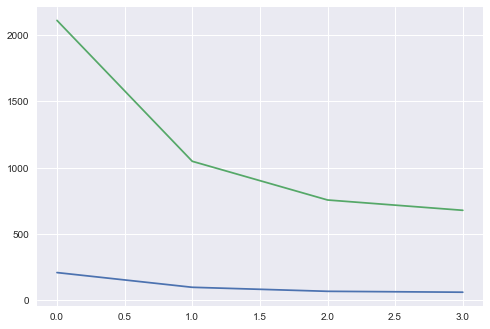

In [446]:
loss_trained, loss_tested = [], []
for epoch in range(4):
    print('Epoch %d' % (epoch + 1))

    shuffled_data = np.random.permutation(len(images_trained))
    images_trained = images_trained[shuffled_data]
    training_labels = training_labels[shuffled_data]

    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(images_trained, training_labels)):

        if i % 100 == 0:
            print('%d of 100 :  Loss %.3f and Accuracy:%d%%' % (i + 1, loss / 100, num_correct))
            loss = 0
            num_correct = 0
        l1, accu = training_cnn_function(im, label, "vanilla")
        loss += l1
        num_correct += accu

    loss_trained.append(loss)

    print("Testing Phase")
    loss = 0
    num_correct = 0

    for im, label in zip(testing_images, testing_labels):
        _,l1, accu = cnn_forward_propagation(im, label)

        loss += l1
        num_correct += accu

    num_tests = len(testing_images)

    loss_tested.append(loss)
    print('Test Loss', loss / num_tests)
    print('Test Accuracy', num_correct / num_tests)

plt.plot(loss_trained)
plt.plot(loss_tested)
plt.show()

With Momentum

In [447]:
def cnn_forward_propagation(image, label):
    output_p = convolution.forward_propogation((image / 255) - 0.5)
    output_p = pooling.forward_prop(output_p) 
    ##ADD one more conv and pooling
    output_p = softmax.fwd_prop(output_p)

    cross_ent_loss = -np.log(output_p[label])
    accuracy_eval = 1 if np.argmax(output_p) == label else 0

    return output_p, cross_ent_loss, accuracy_eval


def training_cnn_function(image, label, learning_rate=0.001, momentum=0.9):
    out, loss, acc = cnn_forward_propagation(image, label)

    gradient_formed = np.zeros(10)
    gradient_formed[label] = -1 / out[label]

    gradient_back = softmax.back_propagation(gradient_formed, learning_rate, "momentum", momentum)
    gradient_back = pooling.back_prop(gradient_back)
    gradient_back = convolution.back_propogation(gradient_back, learning_rate)

    return loss, acc
output_p = convolution.forward_propogation((images_trained[0] / 255) - 0.5)
output_p = pooling.forward_prop(output_p)
#print(output_p.shape)
output_p = softmax.fwd_prop(output_p)

Epoch 1
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 3.812 and Accuracy:45%
201 of 100: Loss 1.417 and Accuracy:62%
301 of 100: Loss 1.114 and Accuracy:70%
401 of 100: Loss 1.029 and Accuracy:70%
501 of 100: Loss 0.880 and Accuracy:69%
601 of 100: Loss 0.704 and Accuracy:77%
701 of 100: Loss 0.551 and Accuracy:83%
801 of 100: Loss 0.757 and Accuracy:77%
901 of 100: Loss 0.686 and Accuracy:78%
Testing Phase
Test Loss 0.8401779565470674
Test Accuracy 0.714
Epoch 2
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 0.613 and Accuracy:81%
201 of 100: Loss 0.479 and Accuracy:87%
301 of 100: Loss 0.492 and Accuracy:85%
401 of 100: Loss 0.560 and Accuracy:84%
501 of 100: Loss 0.524 and Accuracy:83%
601 of 100: Loss 0.365 and Accuracy:89%
701 of 100: Loss 0.369 and Accuracy:89%
801 of 100: Loss 0.549 and Accuracy:80%
901 of 100: Loss 0.692 and Accuracy:76%
Testing Phase
Test Loss 0.5729165762164933
Test Accuracy 0.814
Epoch 3
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 0.

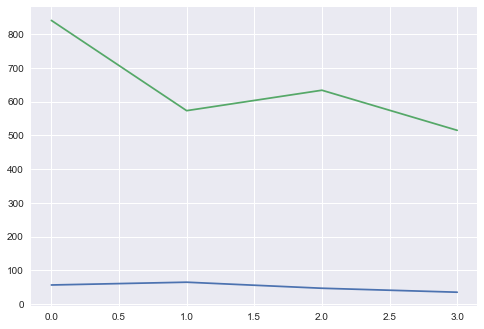

In [448]:
loss_trained, loss_tested = [], []
for epoch in range(4):
    print('Epoch %d' % (epoch + 1))

    shuffled_data = np.random.permutation(len(images_trained))
    images_trained = images_trained[shuffled_data]
    training_labels = training_labels[shuffled_data]

    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(images_trained, training_labels)):

        if i % 100 == 0:
            print('%d of 100: Loss %.3f and Accuracy:%d%%' % (i + 1, loss / 100, num_correct))
            loss = 0
            num_correct = 0

        l1, accu = training_cnn_function(im, label)
        loss += l1
        num_correct += accu

    loss_trained.append(loss)

    print("Testing Phase")
    loss = 0
    num_correct = 0

    for im, label in zip(testing_images, testing_labels):
        _, l1, accu = cnn_forward_propagation(im, label)

        loss += l1
        num_correct += accu

    num_tests = len(testing_images)

    loss_tested.append(loss)
    print('Test Loss', loss / num_tests)
    print('Test Accuracy', num_correct / num_tests)

plt.plot(loss_trained)
plt.plot(loss_tested)
plt.show()

With RMSprop

In [449]:
def rmsprop(x, dx, config=None):
    if config is None: 
        config = {}
        config.setdefault('learning_rate', 1e-2)
        config.setdefault('decay_rate', 0.99)
        config.setdefault('epsilon', 1e-8)
        config.setdefault('cache', np.zeros_like(x))

    next_x = None

    decay_rate = config['decay_rate']
    cache = config['cache']

    cache = decay_rate * cache + (1 - decay_rate) * dx ** 2
    next_x = x - config['learning_rate'] * dx / (np.sqrt(cache) + config['epsilon'])

    config['cache'] = cache

    return next_x, config

Epoch 1
1 of 100 :Loss 0.000 and Accuracy:0%
101 of 100 :Loss 0.404 and Accuracy:86%
201 of 100 :Loss 0.331 and Accuracy:90%
301 of 100 :Loss 0.268 and Accuracy:93%
401 of 100 :Loss 0.176 and Accuracy:97%
501 of 100 :Loss 0.252 and Accuracy:90%
601 of 100 :Loss 0.441 and Accuracy:86%
701 of 100 :Loss 0.267 and Accuracy:94%
801 of 100 :Loss 0.294 and Accuracy:92%
901 of 100 :Loss 0.299 and Accuracy:89%
Testing Phase
Test Loss 0.5561275620603618
Test Accuracy 0.824
Epoch 2
1 of 100 :Loss 0.000 and Accuracy:0%
101 of 100 :Loss 0.217 and Accuracy:94%
201 of 100 :Loss 0.215 and Accuracy:93%
301 of 100 :Loss 0.276 and Accuracy:91%
401 of 100 :Loss 0.284 and Accuracy:93%
501 of 100 :Loss 0.220 and Accuracy:92%
601 of 100 :Loss 0.235 and Accuracy:92%
701 of 100 :Loss 0.419 and Accuracy:91%
801 of 100 :Loss 0.360 and Accuracy:89%
901 of 100 :Loss 0.315 and Accuracy:92%
Testing Phase
Test Loss 0.5100754154882807
Test Accuracy 0.839
Epoch 3
1 of 100 :Loss 0.000 and Accuracy:0%
101 of 100 :Loss 0.

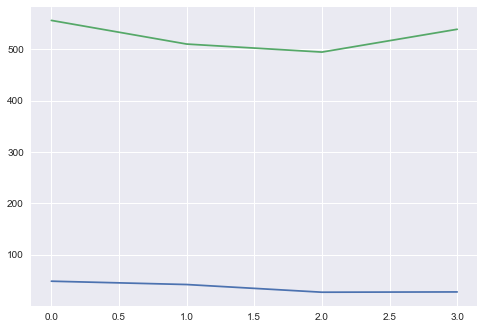

In [450]:
loss_trained, loss_tested = [], []
for epoch in range(4):
    print('Epoch %d' % (epoch + 1))

    shuffled_data = np.random.permutation(len(images_trained))
    images_trained = images_trained[shuffled_data]
    training_labels = training_labels[shuffled_data]

    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(images_trained, training_labels)):

        if i % 100 == 0:
            print('%d of 100 :Loss %.3f and Accuracy:%d%%' % (i + 1, loss / 100, num_correct))
            loss = 0
            num_correct = 0

        l1, accu = training_cnn_function(im, label)
        loss += l1
        num_correct += accu

    loss_trained.append(loss)

    print("Testing Phase")
    loss = 0
    num_correct = 0

    for im, label in zip(testing_images, testing_labels):
        _, l1, accu = cnn_forward_propagation(im, label)

        loss += l1
        num_correct += accu

    num_tests = len(testing_images)

    loss_tested.append(loss)
    print('Test Loss', loss / num_tests)
    print('Test Accuracy', num_correct / num_tests)

plt.plot(loss_trained)
plt.plot(loss_tested)
plt.show()

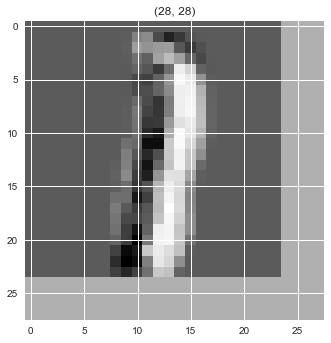

In [451]:
drawing(conv_output[:,:,2])

Q4 With shuffled Data

Vanilla

In [452]:
def cnn_forward_propagation(image, label):
    output_p = convolution.forward_propogation((image / 255) - 0.5)
    output_p = pooling.forward_prop(output_p) 
    output_p2 = convolution1.forward_propogation((image / 255) - 0.5)
    output_p2 = pooling1.forward_prop(output_p2) 
    #output_p = pooling.forward_prop(output_p) 
    ##ADD one more conv and pooling
    output_p = softmax.fwd_prop(output_p)

    cross_ent_loss = -np.log(output_p[label])
    accuracy_eval = 1 if np.argmax(output_p) == label else 0

    return output_p, cross_ent_loss, accuracy_eval


def training_cnn_function(image, label,variant,learning_rate=0.001, momentum=0.9):
    out, loss, acc = cnn_forward_propagation(image, label)

    gradient_formed = np.zeros(10)
    gradient_formed[label] = -1 / out[label]

    gradient_back = softmax.back_propagation(gradient_formed, learning_rate,variant, momentum)
    gradient_back = pooling.back_prop(gradient_back)
    gradient_back = convolution.back_propogation(gradient_back, learning_rate)

    return loss, acc

In [453]:
output_p = convolution.forward_propogation((images_trained[0] / 255) - 0.5)
conv_output=output_p
print(conv_output.shape)
output_p = pooling.forward_prop(output_p)

print(output_p.shape)
output_p = softmax.fwd_prop(output_p)


(28, 28, 4)
(14, 14, 4)


Epoch 1
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 0.265 and Accuracy:93%
201 of 100: Loss 0.214 and Accuracy:94%
301 of 100: Loss 0.243 and Accuracy:92%
401 of 100: Loss 0.097 and Accuracy:98%
501 of 100: Loss 0.152 and Accuracy:96%
601 of 100: Loss 0.121 and Accuracy:99%
701 of 100: Loss 0.185 and Accuracy:94%
801 of 100: Loss 0.239 and Accuracy:91%
901 of 100: Loss 0.145 and Accuracy:96%
Testing Phase
Test Loss 0.47845955499569
Test Accuracy 0.847
Epoch 2
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 0.198 and Accuracy:95%
201 of 100: Loss 0.107 and Accuracy:96%
301 of 100: Loss 0.102 and Accuracy:98%
401 of 100: Loss 0.146 and Accuracy:98%
501 of 100: Loss 0.223 and Accuracy:92%
601 of 100: Loss 0.131 and Accuracy:96%
701 of 100: Loss 0.105 and Accuracy:97%
801 of 100: Loss 0.120 and Accuracy:98%
901 of 100: Loss 0.265 and Accuracy:96%
Testing Phase
Test Loss 0.5006778856917832
Test Accuracy 0.843
Epoch 3
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 0.17

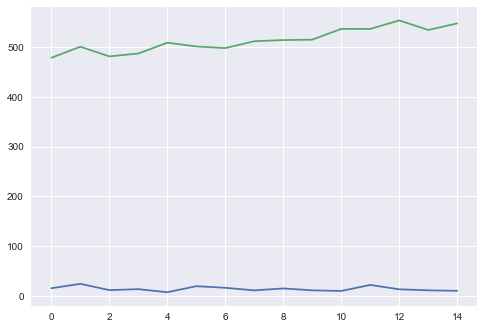

In [454]:
loss_trained, loss_tested = [], []
for epoch in range(15):
    print('Epoch %d' % (epoch + 1))

    shuffled_data = np.random.permutation(len(images_trained))
    images_trained = images_trained[shuffled_data]
    training_labels = training_labels[shuffled_data]

    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(images_trained, training_labels)):

        if i % 100 == 0:
            print('%d of 100: Loss %.3f and Accuracy:%d%%' % (i + 1, loss / 100, num_correct))
            loss = 0
            num_correct = 0
        l1, accu = training_cnn_function(im, label, "vanilla")
        loss += l1
        num_correct += accu

    loss_trained.append(loss)

    print("Testing Phase")
    loss = 0
    num_correct = 0

    for im, label in zip(testing_images, testing_labels):
        _,l1, accu = cnn_forward_propagation(im, label)

        loss += l1
        num_correct += accu

    num_tests = len(testing_images)

    loss_tested.append(loss)
    print('Test Loss', loss / num_tests)
    print('Test Accuracy', num_correct / num_tests)

plt.plot(loss_trained)
plt.plot(loss_tested)
plt.show()

With Momentum

In [455]:
def cnn_forward_propagation(image, label):
    output_p = convolution.forward_propogation((image / 255) - 0.5)
    output_p = pooling.forward_prop(output_p) 
    ##ADD one more conv and pooling
    output_p = softmax.fwd_prop(output_p)

    cross_ent_loss = -np.log(output_p[label])
    accuracy_eval = 1 if np.argmax(output_p) == label else 0

    return output_p, cross_ent_loss, accuracy_eval


def training_cnn_function(image, label, learning_rate=0.001, momentum=0.9):
    out, loss, acc = cnn_forward_propagation(image, label)

    gradient_formed = np.zeros(10)
    gradient_formed[label] = -1 / out[label]

    gradient_back = softmax.back_propagation(gradient_formed, learning_rate, "momentum", momentum)
    gradient_back = pooling.back_prop(gradient_back)
    gradient_back = convolution.back_propogation(gradient_back, learning_rate)

    return loss, acc
output_p = convolution.forward_propogation((images_trained[0] / 255) - 0.5)
output_p = pooling.forward_prop(output_p)
#print(output_p.shape)
output_p = softmax.fwd_prop(output_p)

Epoch 1
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 0.135 and Accuracy:97%
201 of 100: Loss 0.230 and Accuracy:93%
301 of 100: Loss 0.185 and Accuracy:93%
401 of 100: Loss 0.120 and Accuracy:96%
501 of 100: Loss 0.206 and Accuracy:95%
601 of 100: Loss 0.342 and Accuracy:93%
701 of 100: Loss 0.328 and Accuracy:86%
801 of 100: Loss 0.294 and Accuracy:91%
901 of 100: Loss 0.137 and Accuracy:96%
Testing Phase
Test Loss 0.6602004728152627
Test Accuracy 0.823
Epoch 2
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 0.262 and Accuracy:96%
201 of 100: Loss 0.099 and Accuracy:97%
301 of 100: Loss 0.257 and Accuracy:93%
401 of 100: Loss 0.170 and Accuracy:93%
501 of 100: Loss 0.164 and Accuracy:94%
601 of 100: Loss 0.135 and Accuracy:96%
701 of 100: Loss 0.119 and Accuracy:95%
801 of 100: Loss 0.169 and Accuracy:95%
901 of 100: Loss 0.201 and Accuracy:95%
Testing Phase
Test Loss 0.6271737122685893
Test Accuracy 0.82
Epoch 3
1 of 100: Loss 0.000 and Accuracy:0%
101 of 100: Loss 0.1

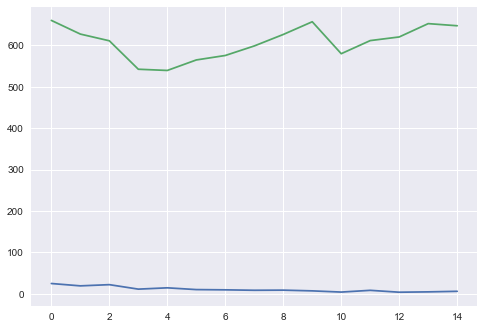

In [456]:
loss_trained, loss_tested = [], []
for epoch in range(15):
    print('Epoch %d' % (epoch + 1))

    shuffled_data = np.random.permutation(len(images_trained))
    images_trained = images_trained[shuffled_data]
    training_labels = training_labels[shuffled_data]

    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(images_trained, training_labels)):

        if i % 100 == 0:
            print('%d of 100: Loss %.3f and Accuracy:%d%%' % (i + 1, loss / 100, num_correct))
            loss = 0
            num_correct = 0

        l1, accu = training_cnn_function(im, label)
        loss += l1
        num_correct += accu

    loss_trained.append(loss)

    print("Testing Phase")
    loss = 0
    num_correct = 0

    for im, label in zip(testing_images, testing_labels):
        _, l1, accu = cnn_forward_propagation(im, label)

        loss += l1
        num_correct += accu

    num_tests = len(testing_images)

    loss_tested.append(loss)
    print('Test Loss', loss / num_tests)
    print('Test Accuracy', num_correct / num_tests)

plt.plot(loss_trained)
plt.plot(loss_tested)
plt.show()

With RMSprop

In [457]:
def rmsprop(x, dx, config=None):
    if config is None: 
        config = {}
        config.setdefault('learning_rate', 1e-2)
        config.setdefault('decay_rate', 0.99)
        config.setdefault('epsilon', 1e-8)
        config.setdefault('cache', np.zeros_like(x))

    next_x = None

    decay_rate = config['decay_rate']
    cache = config['cache']

    cache = decay_rate * cache + (1 - decay_rate) * dx ** 2
    next_x = x - config['learning_rate'] * dx / (np.sqrt(cache) + config['epsilon'])

    config['cache'] = cache

    return next_x, config

Epoch 1
1 of 100 steps: Loss 0.000 and Accuracy:0%
101 of 100 steps: Loss 0.024 and Accuracy:100%
201 of 100 steps: Loss 0.015 and Accuracy:100%
301 of 100 steps: Loss 0.030 and Accuracy:100%
401 of 100 steps: Loss 0.020 and Accuracy:100%
501 of 100 steps: Loss 0.027 and Accuracy:100%
601 of 100 steps: Loss 0.029 and Accuracy:100%
701 of 100 steps: Loss 0.030 and Accuracy:100%
801 of 100 steps: Loss 0.027 and Accuracy:100%
901 of 100 steps: Loss 0.034 and Accuracy:100%
Testing Phase
Test Loss 0.6544182317237215
Test Accuracy 0.858
Epoch 2
1 of 100 steps: Loss 0.000 and Accuracy:0%
101 of 100 steps: Loss 0.015 and Accuracy:100%
201 of 100 steps: Loss 0.026 and Accuracy:100%
301 of 100 steps: Loss 0.013 and Accuracy:100%
401 of 100 steps: Loss 0.016 and Accuracy:100%
501 of 100 steps: Loss 0.029 and Accuracy:100%
601 of 100 steps: Loss 0.021 and Accuracy:100%
701 of 100 steps: Loss 0.023 and Accuracy:99%
801 of 100 steps: Loss 0.032 and Accuracy:99%
901 of 100 steps: Loss 0.033 and Accur

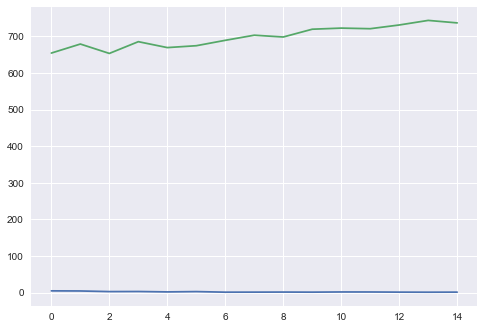

In [458]:
loss_trained, loss_tested = [], []
first_bt,last_bt= [], []

for epoch in range(15):
    
    print('Epoch %d' % (epoch + 1))

    shuffled_data = np.random.permutation(len(images_trained))
    images_trained = images_trained[shuffled_data]
    training_labels = training_labels[shuffled_data]

    loss = 0
    num_correct = 0

    for i, (im, label) in enumerate(zip(images_trained, training_labels)):

        if i % 100 == 0:
            print('%d of 100 steps: Loss %.3f and Accuracy:%d%%' % (i + 1, loss / 100, num_correct))
            loss = 0
            num_correct = 0

        l1, accu = training_cnn_function(im, label)
        loss += l1
        num_correct += accu

    loss_trained.append(loss)

    print("Testing Phase")
    loss = 0
    num_correct = 0

    for im, label in zip(testing_images, testing_labels):
        _, l1, accu = cnn_forward_propagation(im, label)

        loss += l1
        num_correct += accu

    num_tests = len(testing_images)

    loss_tested.append(loss)
    print('Test Loss', loss / num_tests)
    print('Test Accuracy', num_correct / num_tests)

plt.plot(loss_trained)
plt.plot(loss_tested)
plt.show()

Q5

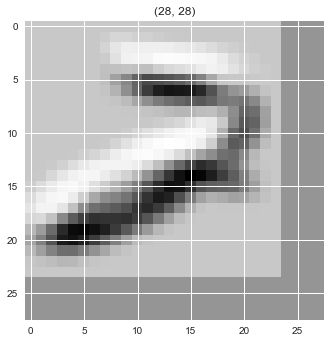

In [459]:
drawing(conv_output[:,:,1])

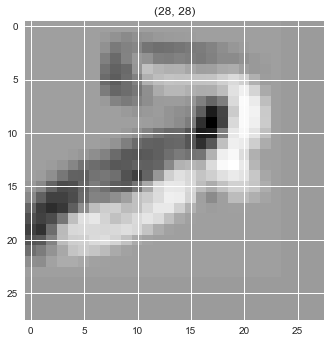

In [460]:
drawing(conv_output[:,:,2])


FinalAccuracy is around 86%